## 自己实现的CLR

看到CLR介绍，第一反应是利用余弦函数的特征，然后自己尝试了一下

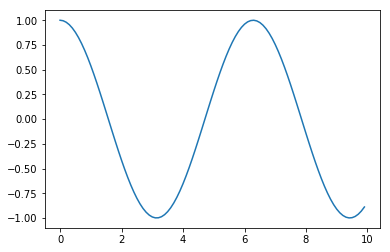

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
x = np.arange(0, 10, 0.1)
y = np.cos(x)
plt.plot(x, y)
plt.show()


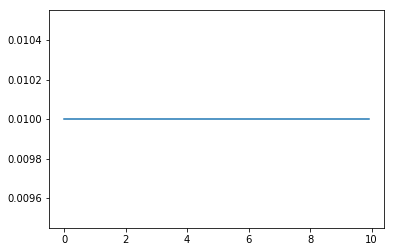

In [2]:
learning_rate = 0.01
plt.plot(x, (x*0 + learning_rate))
plt.show()

偏移和缩放把lr区间缩缩放到[0,1]<br>
只需关心(0, $\pi /2$)的特征区域，然后x/step_size就是我们batch的轮数，每轮的lr变化就是[0,1]

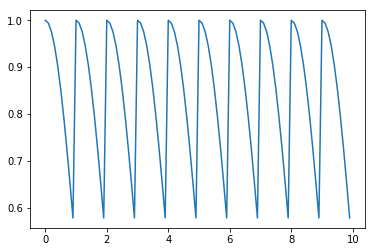

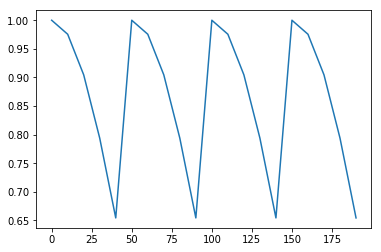

In [3]:
def lr_func(x, lr, step_size=1):
    ret = 0.5 * (np.cos( np.pi/2 * (x%step_size)/step_size) + 1)
    return ret
learning_rate = 0.01
plt.plot(x, lr_func(x, learning_rate))
plt.show()
learning_rate = 0.01
t = np.arange(0, 200, 10)
plt.plot(t, lr_func(t, learning_rate, 50))
plt.show()

我们需要lr在每层中递减，神经网络神深层时候lr过大容易造成loss上升<br>
所以这里每轮利用指数的递减 `np.power(2, x/step_size)`

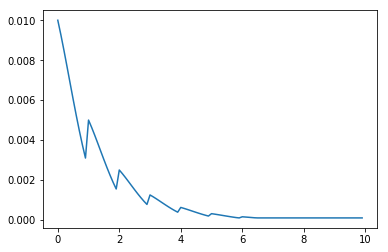

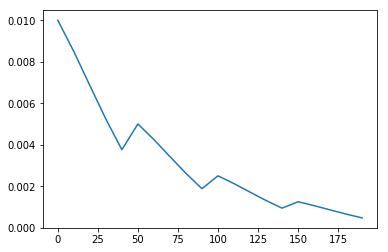

In [4]:
def lr_func2(x, lr, max_lr, base_lr, step_size=1):
    scale = 0.5 * (np.cos( np.pi/2 * (x%step_size)/step_size) + 1) / np.power(2, x/step_size)
    ret = np.maximum(max_lr * scale, base_lr)
    return ret
max_lr = 0.01
base_lr = 0.0001
plt.plot(x, lr_func2(x, learning_rate, max_lr, base_lr))
plt.show()
t = np.arange(0, 200, 10)
plt.plot(t, lr_func2(t, learning_rate, max_lr, base_lr, 50))
plt.show()

下面是参考[CLR](http://teleported.in/posts/cyclic-learning-rate/)的具体实现

In [5]:
def triangular2(iterations, base_lr, max_lr, step_size):
    cycle = np.floor(1+iterations/(2*step_size))
    x = np.abs(iterations/step_size - 2*cycle + 1)
    scale = np.power(0.5, (cycle-1))
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))* scale
    #print(cycle, x, lr)
    return lr

def clr(clr_iterations, base_lr, max_lr, step_size=2000, mode='triangular', gamma=1.0, scale_mode='cycle'):
    scale_fn = None
    if mode == 'triangular':
        scale_fn = lambda x: 1.
        scale_mode = 'cycle'
    elif mode == 'triangular2':
        scale_fn = lambda x: 1/(2.**(x-1))
        scale_mode = 'cycle'
    elif mode == 'exp_range':
        scale_fn = lambda x: gamma**(x)
        scale_mode = 'iterations'
        
    cycle = np.floor(1+clr_iterations/(2*step_size))
    x = np.abs(clr_iterations/step_size - 2*cycle + 1)
    if scale_mode == 'cycle':
        return base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))*scale_fn(cycle)
    else:
        return base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))*scale_fn(clr_iterations)
        


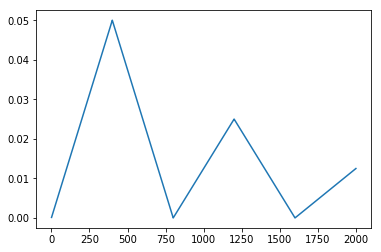

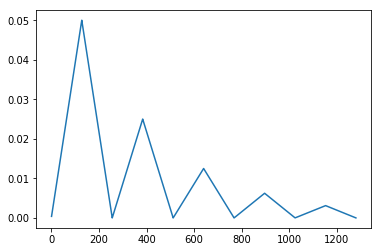

0.00235328125


In [6]:

x1 = np.arange(1, 2000, 0.1)
plt.plot(x1, triangular2(x1/200, 0.00001, 0.05, 2))
plt.show()
batch = 128
total = 128 * 10
x1 = np.arange(1, total, 0.1)
y1 = clr(x1, 0.00001, 0.05, step_size=128, mode='triangular2', gamma=1.0, scale_mode='cycle')
plt.plot(x1, y1)
plt.show()
c = clr(6, 0.00001, 0.05, step_size=128, mode='triangular2', gamma=1.0, scale_mode='cycle')
print(c)

参考资料：
[The Cyclical Learning Rate technique](http://teleported.in/posts/cyclic-learning-rate/)
[Improving the way we work with learning rate](https://techburst.io/improving-the-way-we-work-with-learning-rate-5e99554f163b)

# mnist数据上测试

## epoch 200次， base_lr = 0.0001, max_lr = 0.0001 * 5

In [13]:
import pickle
from collections import defaultdict
# Reload the data
pickle_file = ['saved_result/result.pickle', 'saved_result/result_with_clr.pickle',
              'saved_result/result_50.pickle', 'saved_result/result_with_clr_50.pickle']
data = defaultdict(list)
data_clr = defaultdict(list)
data_50 = defaultdict(list)
data_clr_50 = defaultdict(list)
data_map = [data, data_clr, data_50, data_clr_50]
for i in range(len(data_map)):
    cur_data = data_map[i]
    with open(pickle_file[i], 'rb') as f:
        pickle_data = pickle.load(f)
        cur_data['cost'] = pickle_data['cost_data']
        cur_data['accuracy'] = pickle_data['accuracy_data']
        del pickle_data  # Free up memory
    
# with open(pickle_file[1], 'rb') as f:
#     pickle_data = pickle.load(f)
#     data_clr['cost'] = pickle_data['cost_data']
#     data_clr['accuracy'] = pickle_data['accuracy_data']
#     del pickle_data  # Free up memory


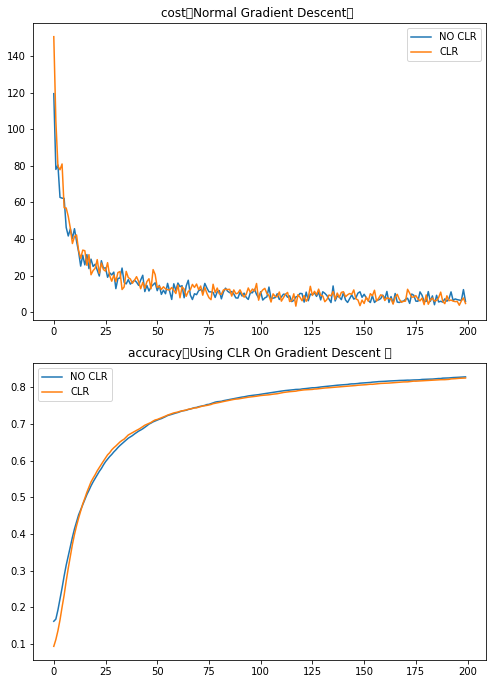

In [22]:
#fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(7, 9.6))
i = np.arange(0, len(data['cost']),1)

fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(7, 9.6))
ax0.plot(i, data['cost'])
ax0.plot(i, data_clr['cost'])
ax0.legend(['NO CLR', 'CLR'])
ax0.set_title('cost(Normal Gradient Descent) ')

ax1.plot(i, data['accuracy'])
ax1.plot(i, data_clr['accuracy'])
ax1.legend(['NO CLR', 'CLR'])
ax1.set_title('accuracy(Using CLR On Gradient Descent )')

plt.tight_layout()
plt.show()

## epoch 50次， learning rate = 0.001

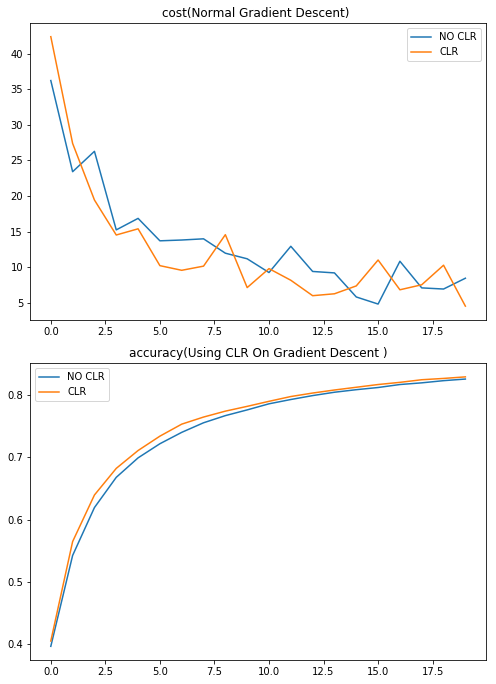

In [23]:
i = np.arange(0, len(data_50['cost']),1)

fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(7, 9.6))
ax0.plot(i, data_50['cost'])
ax0.plot(i, data_clr_50['cost'])
ax0.legend(['NO CLR', 'CLR'])
ax0.set_title('cost(Normal Gradient Descent) ')

ax1.plot(i, data_50['accuracy'])
ax1.plot(i, data_clr_50['accuracy'])
ax1.legend(['NO CLR', 'CLR'])
ax1.set_title('accuracy(Using CLR On Gradient Descent )')
plt.tight_layout()
plt.show()

### 总结：
* learnning rate同样小的时候，使用CLR的accruacy更好，下降快。